In [9]:
import numpy as np 
import matplotlib.pyplot as plt
from utils import *
from motion_models import MM_CTRV
from simulation import *
from scenarios import get_scenario
from filters import EKF_CTRV, UKF_CTRV, filter_cyclic
from scipy.stats import circmean
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [6]:
# FILTER EVALUATION SINGLE SCENARIO

# experiment parameters
T = 0.05
sc_id = '5'
SEED = 1
n_iter = 10
std_r = 0.5
std_phi = np.radians(2)
var_v = 5**2
var_w = np.radians(10)**2
sim_var_v, sim_var_w = 2**2, 0
kf_vec = [
    {'label': 'EKF', 'filter': EKF_CTRV(T, var_v, var_w, std_r, std_phi), 'color': '#DE3163'},
    {'label': 'UKF', 'filter': UKF_CTRV(T, var_v, var_w, std_r, std_phi), 'color': '#32cd32'},
    # {'label': 'UKF low varw', 'filter': UKF_CTRV(T, var_v, np.radians(15)**2, std_r, std_phi), 'color': '#000080'},
]

np.random.seed(SEED)

# generating ground truth
sc = get_scenario(sc_id, T)
n_frames = int(sc['n_frames'])
m_ctrv = MM_CTRV(sim_var_v, sim_var_w)
sim_state = simulate_motion_CTRV(T, n_frames, sc['x_init'], m_ctrv, sc['accw_frames'])

frame_vec = np.arange(n_frames)
n_filters = len(kf_vec)
X = np.zeros((5, n_frames, n_filters, n_iter)) # to store average state estimation
Err = np.zeros((5, n_frames, n_filters, n_iter)) # to store track estimate errors
Err_meas = np.zeros((n_frames, n_iter)) # to store meas error

for iter_ in range(n_iter):
    # generate measurements
    meas_pol = simulate_measurements_polar(sim_state, std_r, std_phi, 0.1)

    X_iter = np.zeros((5, n_frames, n_filters))
    Err_iter = np.zeros((5, n_frames, n_filters))

    Err_meas[:, iter_] = (meas_pol[IMX, :] - sim_state[IX, :])**2 + (meas_pol[IMY, :] - sim_state[IY, :])**2

    for i, kf in enumerate(kf_vec):
        kf_f = kf['filter']
        for frame in frame_vec:
            meas = np.array([meas_pol[IMR, frame], meas_pol[IMPHI, frame]])
            filter_cyclic(frame, kf_f, meas)
            X_iter[:, frame, i] = kf_f.x
            Err_iter[:, frame, i] = kf_f.x - sim_state[:, frame]
            
    X[:, :, :, iter_] = X_iter
    Err_iter[IPHI, :, :] = wrap_angle2(Err_iter[IPHI, :, :])
    Err[:, :, :, iter_] = Err_iter

# getting metrics
Xm = np.mean(X, axis=3)
Xm[IPHI, :, :] = circmean(X[IPHI, :, :, :], axis=2, low=-np.pi, high=np.pi)
rmse_meas = np.sqrt(np.mean(Err_meas, axis=1))
rmse_pos = np.sqrt(np.mean(Err[IX, :, :, :]**2 + Err[IY, :, :, :]**2, axis=2))
rmse_phi = np.degrees(np.sqrt(circmean(Err[IPHI, :, :, :]**2, axis=2)))
rmse_vel = np.sqrt(np.mean(Err[IV, :, :, :]**2, axis=2))
rmse_omg = np.degrees(np.sqrt(np.mean(Err[IW, :, :, :]**2, axis=2)))

# visualization
Xm[IPHI, :, :] = np.degrees(Xm[IPHI, :, :])
Xm[IW, :, :] = np.degrees(Xm[IW, :, :])

In [10]:
plot_options = [
    {'ylabel': 'RMSE Pos (m)', 'data': rmse_pos, 'plot_meas': True},
    {'ylabel': 'RMSE Heading (deg)', 'data': rmse_phi},
    {'ylabel': 'RMSE Velocity (m/s)', 'data': rmse_vel},
    {'ylabel': 'RMSE Turn rate (deg/s)', 'data': rmse_omg},
]
time_vec = frame_vec*T

fig_rmse = make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.03)
for j, p in enumerate(plot_options):
    if p.get('plot_meas', False):
        fig_rmse.add_trace(
            go.Scatter(
                x=time_vec, y=rmse_meas, mode='markers', name='meas', marker=dict(size=3)), 
            row=j+1, col=1)
    for i, kf in enumerate(kf_vec):
        fig_rmse.add_trace( 
            go.Scatter(
                x=time_vec, y=p['data'][:, i], mode='lines', 
                legendgroup=kf['label'], name=kf['label'], showlegend=True if j==0 else False,
                line=dict(color=kf['color'], width=2)),
            row=j+1, col=1)
    fig_rmse.update_yaxes(title_text=p['ylabel'], row=j+1, col=1)
fig_rmse.update_xaxes(title_text='Time (s)', row=4, col=1)
fig_rmse.update_layout(
    template="plotly_dark",
    autosize=True,
    width=800,
    height=800,
    margin=dict(l=20, r=20, t=40, b=20),
    showlegend=True,
    legend=dict(yanchor="top", y=1.0, xanchor="left", x=0.36),
    title_text="Root Mean Square Errors")
fig_rmse.show()
fig_rmse.write_html("rmse_comparison.html", full_html=False, include_plotlyjs='cdn')


plot_options = [
    # {'grid_pos': (0, 1), 'index': IX, 'ylabel': 'X (m)', 'meas_index': IMX},
    # {'grid_pos': (0, 2), 'index': IY, 'ylabel': 'Y (m)', 'meas_index': IMY},
    {'grid_pos': (1, 1), 'index': IPHI, 'ylabel': 'Heading (deg)', 'fn': np.degrees},
    {'grid_pos': (1, 2), 'index': IV, 'ylabel': 'Velocity (m/s)'},
    {'grid_pos': (2, 1), 'index': IW, 'ylabel': 'Turn rate (deg)', 'fn': np.degrees},
]
line_truth = dict(color='white', width=1, dash='dot')

fig_state = make_subplots(
    rows=3, cols=2, 
    specs=[
        [{'rowspan': 3}, {}],
        [None, {}],
        [None, {}]])
fig_state.add_trace( 
    go.Scatter(
        x=meas_pol[IMX, :], y=meas_pol[IMY, :], mode='markers', name='meas', marker=dict(size=3)),
    row=1, col=1)
fig_state.add_trace( 
    go.Scatter(
        x=sim_state[IX, :], y=sim_state[IY, :], mode='lines', name='truth', legendgroup='truth', line=line_truth),
    row=1, col=1)
for i, kf in enumerate(kf_vec):
    fig_state.add_trace( 
        go.Scatter(
            x=Xm[IX, :, i], y=Xm[IY, :, i], mode='lines', 
            legendgroup=kf['label'], name=kf['label'], showlegend=True,
            line=dict(color=kf['color'], width=2)),
        row=1, col=1)
fig_state.update_yaxes(title_text='Y (m)', row=1, col=1)
fig_state.update_xaxes(title_text='X (m)', row=1, col=1)
for j, p in enumerate(plot_options):
    sim_var = sim_state[p['index'], :]
    if p.get('fn', False):
        sim_var = p['fn'](sim_var)
    for i, kf in enumerate(kf_vec):
        fig_state.add_trace(
            go.Scatter(
                x=time_vec, y=Xm[p['index'], :, i], mode='lines', 
                legendgroup=kf['label'], name=kf['label'], showlegend=False,
                line=dict(color=kf['color'], width=2)),
            row=j+1, col=2)
    fig_state.add_trace(
        go.Scatter(
            x=time_vec, y=sim_var, mode='lines', 
            legendgroup='truth', name='truth', showlegend=False,
            line=line_truth),
        row=j+1, col=2)
    fig_state.update_yaxes(title_text=p['ylabel'], row=j+1, col=2)
fig_state.update_xaxes(title_text='Time (s)', row=3, col=2)
fig_state.update_layout(
    template="plotly_dark",
    autosize=True,
    width=800,
    height=600,
    margin=dict(l=20, r=20, t=40, b=20),
    showlegend=True,
    legend=dict(yanchor="top", y=0.25, xanchor="left", x=0.03),
    title_text="Mean state")
fig_state.show()
fig_state.write_html("mean_state.html", full_html=False, include_plotlyjs='cdn')

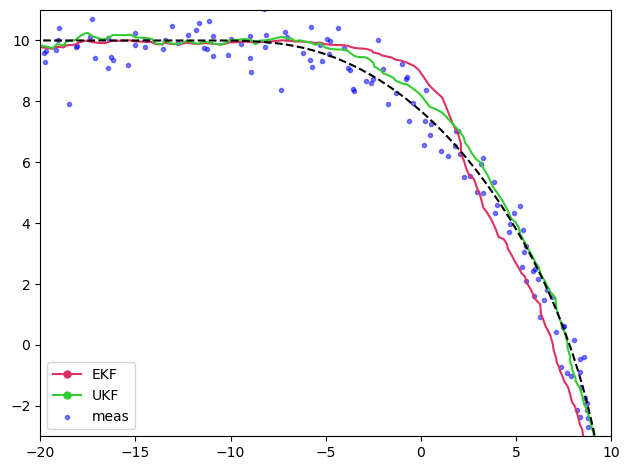

In [70]:
# Generating GIF
from matplotlib.animation import FuncAnimation, PillowWriter

kf_vec = [
    {'label': 'EKF', 'filter': EKF_CTRV(T, var_v, var_w, std_r, std_phi), 'color': '#DE3163'},
    {'label': 'UKF', 'filter': UKF_CTRV(T, var_v, var_w, std_r, std_phi), 'color': '#32cd32'},
    # {'label': 'UKF low varw', 'filter': UKF_CTRV(T, var_v, np.radians(15)**2, std_r, std_phi), 'color': '#000080'},
]

X_iter = X[:, :, :, 3]
frame_0 = int(4/T)
X_ekf = X_iter[:, :, 0]
X_ukf = X_iter[:, :, 1]

def update_line_point(ax, frame, X, kf: dict):
    point, = ax.plot(X[IX, frame], X[IY, frame], marker='.', ms=10, color=kf['color'], label=kf['label'])
    line, = ax.plot(X[IX, 0:frame+1], X[IY, 0:frame+1], color=kf['color'])
    return point, line

def animate(i):
    frame = i + frame_0
    ax.clear()
    ax.set_xlim(-20, 10)
    ax.set_ylim(-3, 11)
    ekf_point, ekf_line = update_line_point(ax, frame, X_ekf, kf_vec[0])
    ukf_point, ukf_line = update_line_point(ax, frame, X_ukf, kf_vec[1])

    sim_point, = ax.plot(sim_state[IX, frame], sim_state[IY, frame], marker='s', ms=7, color='black')
    sim_line, = ax.plot(sim_state[IX, 0:frame+1], sim_state[IY, 0:frame+1], 'k--')
    
    meas_point = ax.scatter(meas_pol[IMX, 0:frame+1], meas_pol[IMY, 0:frame+1], marker='.', alpha=0.5, color='blue', label='meas')
    ax.legend(loc='lower left')

    return ekf_point, ekf_line, ukf_point, ukf_line, meas_point, sim_point, sim_line
        
fig, ax = plt.subplots()
ani = FuncAnimation(fig, animate, interval=40, blit=True, repeat=True, frames=130) # 140
fig.tight_layout()
ani.save("example.gif", dpi=300, writer=PillowWriter(fps=20))

In [37]:
sim_state[IX, i]

-39.50642874313346